# IAcobus: Neural Networks Tutorial

This notebook demonstrates the functionality of the custom-written library **IAcobus** for constructing, training, and analysing neural networks. The examples have been selected with a reductionist approach, aiming to convey two key points: i) how to use the library, including how to define the architecture and set the training parameters; and ii) the underlying rationale for addressing different problems, drawing from mathematical principles.

Please note that this tutorial does not aim to showcase best practices or the selection of optimal parameters, but rather provides a general overview of the IAcobus framework.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from iacobus import IAcobus

## Example 1: one-to-one fit of numerical data

This example shows how to train the neural network to fit a simple function of the form $f(x) = 2x^2$. The training relies on noisy data, and we use the gradient descendent with momentum as minimisation algorithm. After training, $x$ values are forward-propagated to obtain the predictions.

A total of 32 $\times$ ReLU units are used on each hidden layers. The output layer contains a single neuron with linear activation function.

In [4]:
# Generate synthetic data with noise
def scalar_function(x):
    return 2*x**2

n_vals = 100
noise = 10
X_test = np.linspace(-10,10, n_vals).reshape(1, n_vals)
Y_test = scalar_function(X_test) + noise*np.random.randn(1, n_vals)

In [5]:
# Create the network
topology = [16, 64, 1]
activation_funcs = ['sigmoid',
                    'sigmoid',
                    'linear']
n_inputs = 1
ryc = IAcobus(n_inputs,
                topology,
                activation_funcs,
                cost_func='mse')

cost = ryc.train(X_test, Y_test,
                 num_epochs=10_000,
                 batch_size=10,
                 learning_rate=1e-4,
                 algorithm='gdm',
                 verbose=True)

Cost: 76.17542;   Epoch: 9990/10000: 100%|██████████| 10000/10000 [00:26<00:00, 384.31it/s]


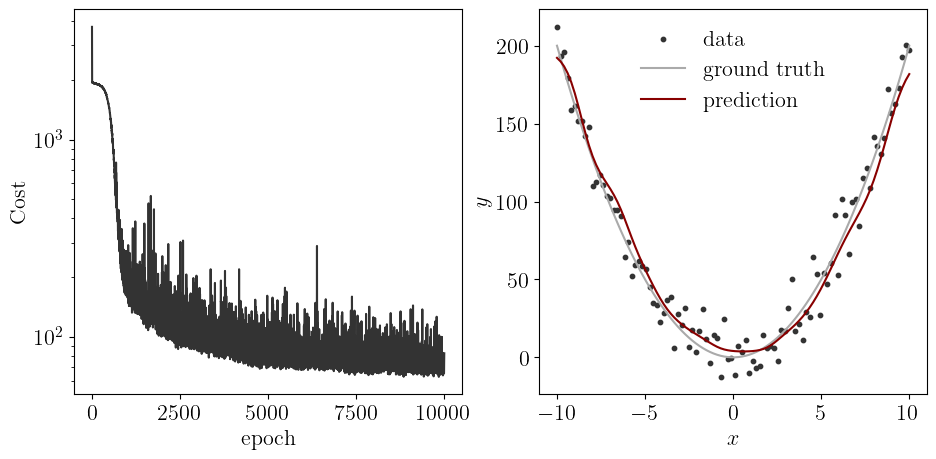

In [6]:
# Plots 
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)

fig, axs = plt.subplots(ncols=2, figsize=(11, 5))
ax_cost = axs[0]
ax_result = axs[1]

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_yscale('log')

ax_result.scatter(X_test.T,
               Y_test.T,
               s=10,
               color="#333333",
               label="data")


ax_result.plot(X_test.T,
               scalar_function(X_test.T),
                color="#aaaaaa",
                label="ground truth")


ax_result.plot(X_test.T,
               ryc.forward(X_test).T,
                color="#880000",
                label="prediction")

ax_result.legend(frameon=False)

ax_result.set_xlabel(r"$x$")
ax_result.set_ylabel(r"$y$")

plt.show()


## Example 2: many-to-one fit of numerical data

We train a neural network to fit a function of the form $z(x,y) = 2x^2+ 3y^2$, which defines a paraboloid. The training relies on noisy data, and after training, pairs of $x,y$ values are forward-propagated to obtain predictions for $z$.

We use 3 hidden layers, where the first two use sigmoids as activation functions. The last layer is a single neuron with linear activation function.

In [7]:
# Generate synthetic data with noise
def scalar_function_two_variables(X,Y):
    return 2*X**2 + 3*Y**2

n_vals = 20
noise = 10
X_test = np.linspace(-10,10, n_vals)
Y_test = np.linspace(-10,10, n_vals)

X_test_grid, Y_test_grid = np.meshgrid(X_test,Y_test)
X_test_grid_flat = X_test_grid.reshape(1, n_vals*n_vals)
Y_test_grid_flat = Y_test_grid.reshape(1, n_vals*n_vals)
XY_test_grid_flat = np.vstack( (X_test_grid_flat.reshape(1, n_vals*n_vals), Y_test_grid_flat.reshape(1, n_vals*n_vals)) )

Z_test = scalar_function_two_variables(X_test_grid_flat, Y_test_grid_flat) + noise*np.random.randn(1, n_vals*n_vals)

In [12]:
# Create the network
topology = [128, 512, 1]
activation_funcs = ['relu',
                    'relu',
                    'linear']
n_inputs = 2
ryc = IAcobus(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='mse')

cost = ryc.train(XY_test_grid_flat,
                 Z_test,
                 num_epochs=800,
                 batch_size=10,
                 learning_rate=1e-3, 
                 verbose=True)

Cost: 104.04247;   Epoch: 790/800: 100%|██████████| 800/800 [01:02<00:00, 12.81it/s] 


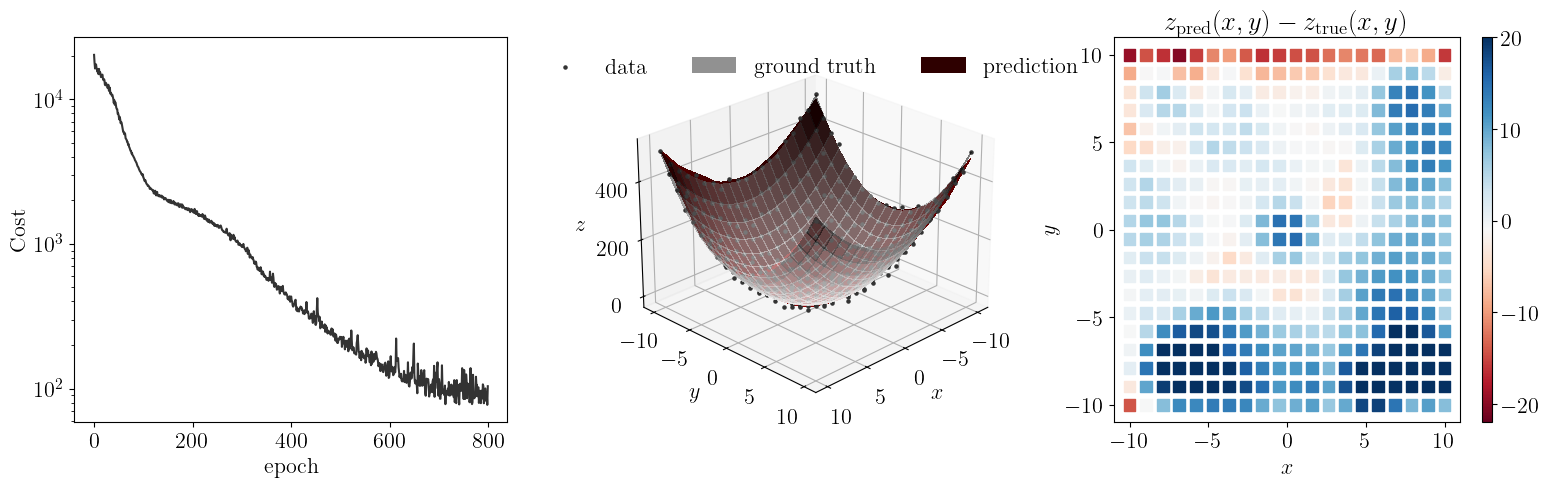

In [13]:
# Plots
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)

fig = plt.figure( figsize=(19, 5) )

# Panel cost
ax_cost = fig.add_subplot(1, 3, 1)
ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_yscale('log')

# Panel 3d fit
ax_result = fig.add_subplot(1, 3, 2, projection='3d')

ax_result.scatter(X_test_grid_flat.T,
                  Y_test_grid_flat.T,
                  Z_test,
                  s=5,
                  color="#333333",
                  depthshade=0,
                  label="data")

z_theo = scalar_function_two_variables(X_test_grid,Y_test_grid)
surf = ax_result.plot_surface(X_test_grid,
                              Y_test_grid,
                              z_theo,
                              cmap=cm.Greys,
                              alpha=0.5,
                              linewidth=0,
                              antialiased=False,
                              label="ground truth")

predictions_parabolla = ryc.forward(XY_test_grid_flat).reshape(n_vals, n_vals)
ax_result.plot_surface(X_test_grid,
                        Y_test_grid,
                        predictions_parabolla,
                        color="#880000",
                        linewidth=0,
                        antialiased=False,
                        label="prediction")

ax_result.view_init(elev=25,
                    azim=45)

ax_result.legend(loc="upper center",
                 ncol=3,
                 frameon=False)

ax_result.set_xlabel(r"$x$")
ax_result.set_ylabel(r"$y$")
ax_result.set_zlabel(r"$z$")


# ---
ax_residual = fig.add_subplot(1, 3, 3)
ax_residual.set_ylabel(r"$y$")
ax_residual.set_xlabel(r"$x$")
ax_residual.set_title(r"$z_\mathrm{pred}(x,y) - z_\mathrm{true}(x,y)$")

rel_residuals = predictions_parabolla - z_theo

residuals_plot = ax_residual.scatter(X_test_grid_flat, Y_test_grid_flat,
                                        c = rel_residuals,
                                        marker="s",
                                        s= 70,
                                        cmap=cm.RdBu,
                                        vmin=20,
                                        vmax=-20)

cbar_res = plt.colorbar(residuals_plot,
                        ax=ax_residual,
                        orientation='vertical',
                        location='right',
                        aspect=40)


plt.show()


## Example 3: Many-to-many, fitting a vectorial field

We will use the neural network to find an approximate solution to interpolate a vectorial field of the form $\mathbb{R}^2 \rightarrow \mathbb{R}^2$. We consider the rotating vectorial field $\mathbf{r}(x,y) = R \sin(-\theta)\mathbf{\hat{i}} + R\cos(\theta) \mathbf{\hat{i}}$, where $\theta \equiv \mathrm{atan}(y/x)$ and $R\equiv \sqrt{x^2 + y^2}$. To make the problem more realistic, the values for the training vectors incoporate random Gaussian noise $\xi = \mathcal{N}(0,1)$ and then $\mathbf{r}_\mathrm{train} = \mathbf{r} + R\xi$.

In [70]:
# Created the data and prepare it for the traiing 
def vector_field(x, y, noise):

    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y, x)
    theta = np.where(theta<0, 2*np.pi + theta, theta)
    
    x_true = r*np.sin(-theta)
    y_true = r*np.cos(theta)
    x_comp = x_true + r*noise*np.random.randn(x.shape[0], x.shape[1])
    y_comp = y_true + r*noise*np.random.randn(x.shape[0], x.shape[1])

    return x_comp, y_comp, x_true, y_true

n_vals = 20
noise = 0.20
X_test = np.linspace(-5, 5, n_vals)
Y_test = np.linspace(-5, 5, n_vals)

X_test = X_test.reshape(1,n_vals)
Y_test = Y_test.reshape(1,n_vals)

X_test_grid, Y_test_grid = np.meshgrid(X_test, Y_test)
X_test_grid_flat = X_test_grid.reshape(1, n_vals*n_vals)
Y_test_grid_flat = Y_test_grid.reshape(1, n_vals*n_vals)
XY_test = np.vstack((X_test_grid_flat, Y_test_grid_flat))

u, v, u_true, v_true =  vector_field(X_test_grid_flat, Y_test_grid_flat, noise)
UV_test = np.vstack((u,v))
UV_true = np.vstack((u_true, v_true))

In [73]:
# Create the network
n_inputs = 2
topology = [16, 16, 2]
activation_funcs = ['relu',
                    'relu',
                    'linear']

ryc = IAcobus(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='mse')

cost = ryc.train(XY_test,
                 UV_test,
                 num_epochs = 1000,
                 batch_size = 5,
                 learning_rate = 1e-3,
                 algorithm = 'adam',
                 verbose=False)


UV_pred = ryc.forward(XY_test)


100%|██████████| 1000/1000 [00:15<00:00, 62.51it/s]


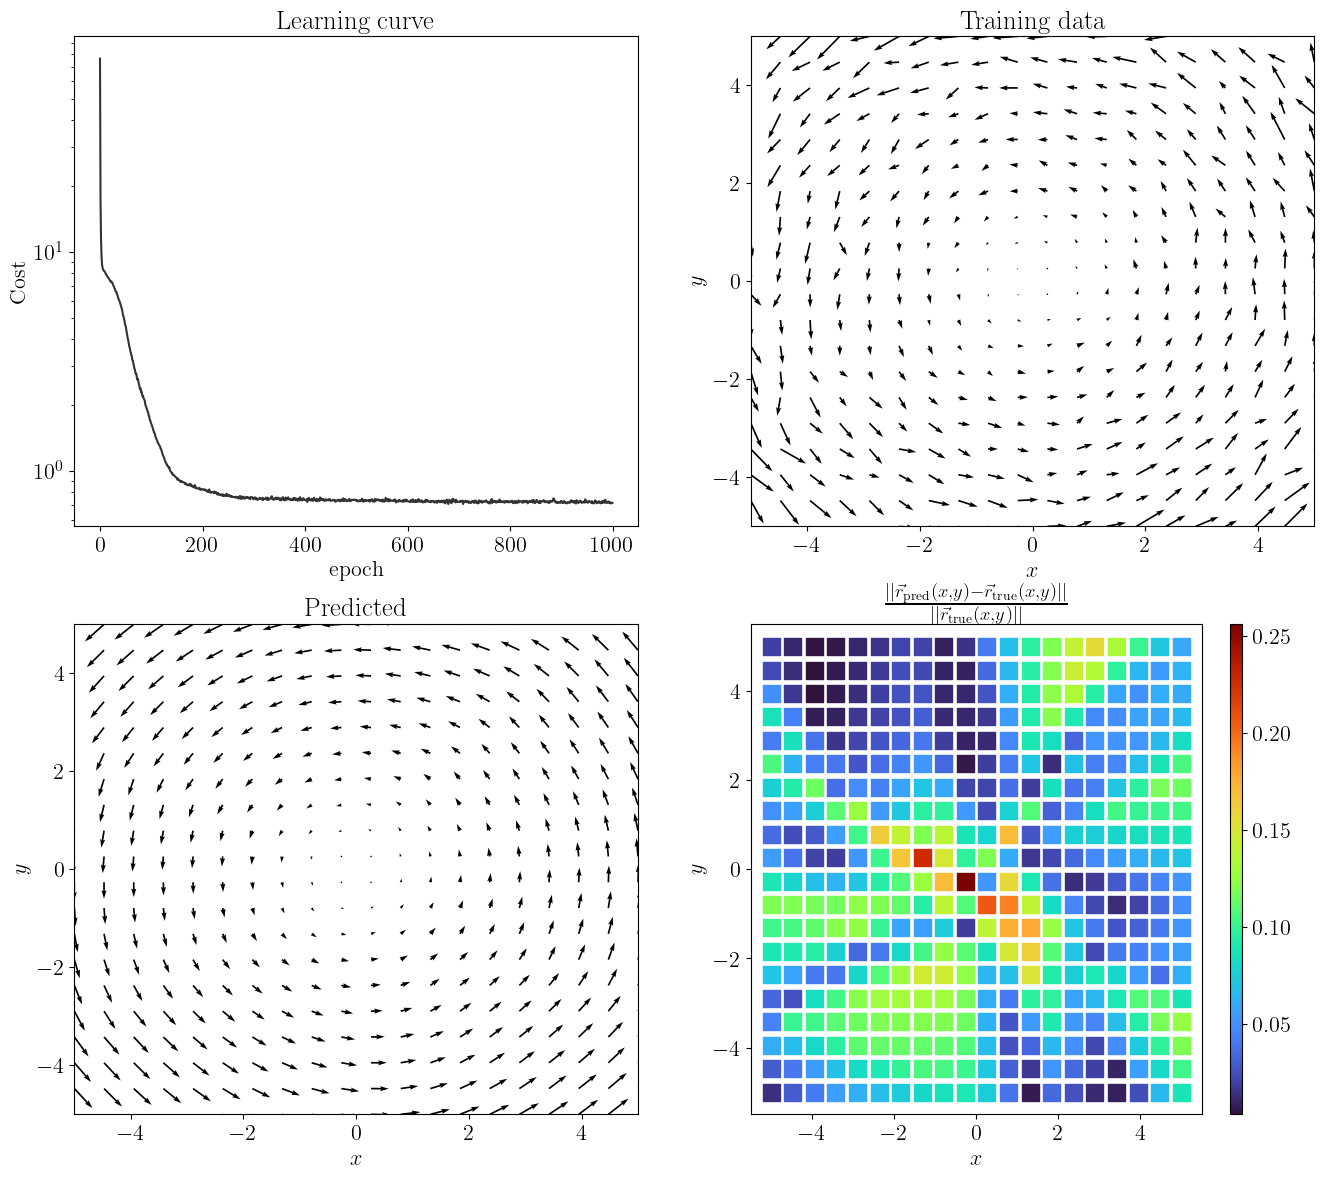

In [74]:
# Plots
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)

fig = plt.figure( figsize=(16, 14) )

#---

ax_cost = fig.add_subplot(2, 2, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_yscale('log')
ax_cost.set_title("Learning curve")

#---

ax_input = fig.add_subplot(2, 2, 2)
ax_input.quiver(X_test_grid_flat, Y_test_grid_flat, u, v)

ax_input.set_ylabel(r"$y$")
ax_input.set_xlabel(r"$x$")
ax_input.set_ylim([-5, 5])
ax_input.set_xlim([-5, 5])
ax_input.set_title("Training data")

#---
ax_predicted = fig.add_subplot(2, 2, 3)
ax_predicted.quiver(X_test_grid_flat, Y_test_grid_flat,
                    UV_pred[0,:], UV_pred[1,:])

ax_predicted.set_ylabel(r"$y$")
ax_predicted.set_xlabel(r"$x$")
ax_predicted.set_ylim([-5, 5])
ax_predicted.set_xlim([-5, 5])
ax_predicted.set_title("Predicted")



#---
ax_diff = fig.add_subplot(2, 2, 4)

diff_norm = np.linalg.norm(UV_pred - UV_true, axis=0)/np.linalg.norm(UV_true, axis=0)
diff_plot = ax_diff.scatter(X_test_grid_flat, Y_test_grid_flat,
                                c = diff_norm,
                                marker="s",
                                s= 150,
                                cmap=cm.turbo)

ax_diff.set_ylabel(r"$y$")
ax_diff.set_xlabel(r"$x$")
ax_diff.set_title(r"$\frac{|| \vec{r}_\mathrm{pred}(x,y) - \vec{r}_\mathrm{true}(x,y) ||}{|| \vec{r}_\mathrm{true}(x,y) ||}$")

cbar_diff_uv = plt.colorbar(diff_plot,
                                ax=ax_diff,
                                orientation='vertical',
                                location='right',
                                aspect=40)


plt.show()

## Example 4: Binary classification

In this example is described how to use the library in a binary classification problem. Using polar coordinates $r = r(\theta)$ we consider two partially overlapping distributions, $r_1 \sim \mathcal{N}(R_1, \sigma_1)$ and $r_2 \sim \mathcal{N}(R_2, \sigma_2)$. These two  populations define concentric circles and each of them is labeled with either $y=1$ or $y=0$. Note that the label is independent of the $\theta$ argument. The task of the neural network is to classify the two populations, learning the irrelevance of $\theta$ to describe the data class. That is, we will obtain conditional probabilities $p(y=1 | r,\theta) \simeq p(y=1 | r) $.

For the selected values $R_1$, $R_2$ and $\sigma_1$, $\sigma_2$ the distributions show a significant overlap. Thus, the maximum accuracy that we can achieve from Neural Network predictions is that determined from the known normal distributions. Given the probability density functions $r_1$ and $r_2$, the relative *height* indicates the chance of classifying in one or other distribution. The probability of a radius $r$ to belong to the ditribution $r_1$ is then $p(r | r_1) = \frac{r_1(r)}{r_1(r) + r_2(r)}$

In [11]:
# Generate data in polar coordinates with significant noise
n_vals = 100
noise = 0.3
R1 = 1
R2 = 2
theta_test = np.linspace(0, 2*np.pi, n_vals).reshape(1, n_vals)
R_test1 = noise*np.random.randn(1, n_vals) + R1
R_test2 = noise*np.random.randn(1, n_vals) + R2

thetas = np.hstack( (theta_test,theta_test) )
Rs = np.hstack( (R_test1, R_test2) )
X = np.vstack((thetas, Rs))
labels = np.hstack( (np.zeros(n_vals), np.ones(n_vals)) ).reshape(1, 2*n_vals)

In [12]:
# Create the network and training
topology = [2,1]
activation_funcs = ['relu',
                    'sigmoid']
n_inputs = 2
ryc = IAcobus(n_inputs,
                    topology,
                    activation_funcs,
                    cost_func='bin-cross-entropy')

cost = ryc.train(X,
                 labels,
                 num_epochs=1000,
                 batch_size=10,
                 learning_rate=1e-2,
                 verbose=False)


pred_labels = ryc.forward(X).reshape(2*n_vals, 1)
#pred_labels = np.where(pred_labels > 0.5, 1, 0) # We could make a hard threshold to attribute a class to the probabilities

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:19<00:00, 50.44it/s]


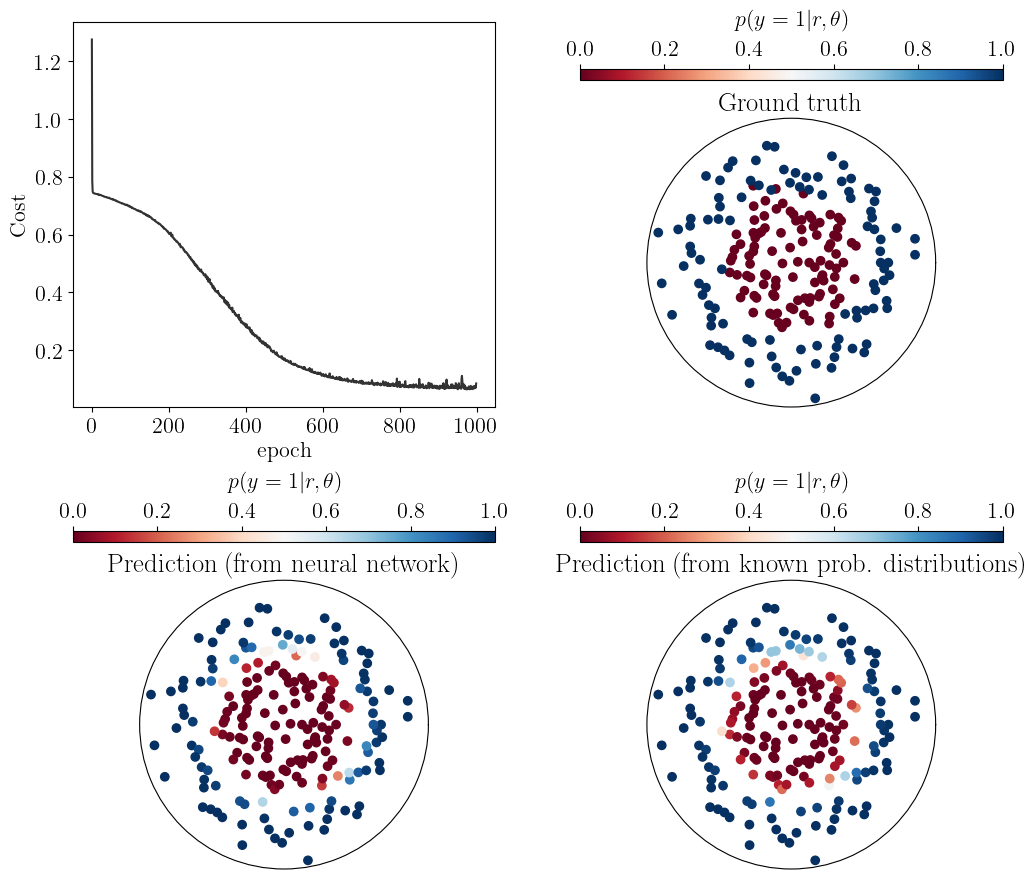

In [13]:
# Plot
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}


plt.rc('text', usetex=True)
plt.rc('font', **font)


fig = plt.figure( figsize=(12, 11) )

#---

ax_cost = fig.add_subplot(2, 2, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
#ax_cost.set_yscale('log')

#---

ax_referece = fig.add_subplot(2, 2, 2, projection='polar')

ax_referece.set_xticks([])
ax_referece.set_yticks([])
ax_referece.set_title("Ground truth")

labels_reference_plot = ax_referece.scatter(thetas,
                                            Rs,
                                            c = labels,
                                            cmap=cm.RdBu,
                                            vmin=0.0,
                                            vmax=1.0)

cbar_ref = plt.colorbar(labels_reference_plot,
                        ax=ax_referece,
                        orientation='horizontal',
                        location='top',
                        pad=0.1,
                        aspect=40)

cbar_ref.set_label(r'$p(y = 1 | r, \theta)$',  labelpad=10)

#---

ax_result = fig.add_subplot(2, 2, 3, projection='polar')

ax_result.set_xticks([])
ax_result.set_yticks([])
ax_result.set_title("Prediction (from neural network)")

labels_predicted_plot = ax_result.scatter(thetas,
                                            Rs,
                                            c = pred_labels,
                                            cmap=cm.RdBu,
                                            vmin=0.0,
                                            vmax=1.0)

cbar_res = plt.colorbar(labels_predicted_plot,
                    ax=ax_result,
                    orientation='horizontal',
                    location='top',
                    pad=0.1,
                    aspect=40)

cbar_res.set_label(r'$p(y = 1 | r, \theta)$',  labelpad=10)

#---

def gauss_func(x, mu, sigma):
    return np.exp( - (x-mu)**2 /(2*sigma**2)) / \
           np.sqrt(2*np.pi*sigma**2)

pR1 = gauss_func(Rs, R1, noise)
pR2 = gauss_func(Rs, R2, noise)
p_class_R1 = pR1/(pR1 + pR2)


ax_from_probs = fig.add_subplot(2, 2, 4, projection='polar')

ax_from_probs.set_xticks([])
ax_from_probs.set_yticks([])
ax_from_probs.set_title("Prediction (from known prob. distributions)")

labels_from_probs_plot = ax_from_probs.scatter(thetas,
                                            Rs,
                                            c = 1-p_class_R1,
                                            cmap=cm.RdBu,
                                            vmin=0.0,
                                            vmax=1.0)

cbar_res = plt.colorbar(labels_from_probs_plot,
                    ax=ax_from_probs,
                    orientation='horizontal',
                    location='top',
                    pad=0.1,
                    aspect=40)

cbar_res.set_label(r'$p(y = 1 | r, \theta)$',  labelpad=10)

#---
plt.show()

## Example 5: Multilabel classification

### 5.1 Basic example of multilabel classification 

First, we use t IACobus on a simple multilabel classification problem involving a set of points in the $x, y$ plane: four normally distributed clusters with different radial variances, partially overlapping with each other. These points are classified based on their $x, y$ coordinates. Using a neural network, we artificially create decision boundaries between the point clouds.

Next, as in the binary classification example above, we compare the results with theoretical predictions. Given the probability density functions $\rho_1, \rho_2, \rho_3, \rho_4$ for the radius relative to the centre of each population, the *height* of these functions indicates the probability of classifying a point into one of the distributions. The probability that a point with radius $r = \sqrt{ (x-x_0)^2 + (y-y_0)^2}$ belongs to class $n$ which centre is at $x_0, y_0$ is given by:

$$ p_n(r \mid x, y) = \frac{\rho_n(r | x_0, y_0)}{\sum_{i=1}^{N} \rho_i(r | x_0, y_0)} $$

We then show the probability of correctly classifying the data based on the theoretical distribution and compare it with the predictions made by the neural network.

In [14]:
n_vals = 200

def create_spot(X0, Y0, sigma_r, n_vals):

    # Generate random angles and radii
    thetas = np.random.uniform(0, 2 * np.pi, n_vals)
    #radii = np.sqrt(np.random.uniform(0, radius**2, n_vals))
    radii = np.random.randn(n_vals)*sigma_r
    
    X = X0 + radii * np.cos(thetas)
    Y = Y0 + radii * np.sin(thetas)

    X = X.reshape(1, n_vals)
    Y = Y.reshape(1, n_vals)

    XY = np.vstack((X,Y))
    return XY

S1_r0 = [-1.75, 0]
S2_r0 = [1.75, 0]
S3_r0 = [0, 1.75]
S4_r0 = [0, -1.75]
S1_sigma_r = 1
S2_sigma_r = 1.25
S3_sigma_r = 1
S4_sigma_r = 1.5
Spot1 =  create_spot(S1_r0[0], S1_r0[1], S1_sigma_r, n_vals)
Spot2 =  create_spot(S2_r0[0], S2_r0[1], S2_sigma_r, n_vals)
Spot3 =  create_spot(S3_r0[0], S3_r0[1], S3_sigma_r, n_vals)
Spot4 =  create_spot(S4_r0[0], S4_r0[1], S4_sigma_r, n_vals)

XY_spots = np.hstack((Spot1,Spot2,Spot3, Spot4))
Y_labels = np.hstack( (np.zeros(n_vals),
                       np.ones(n_vals),
                       np.ones(n_vals)*2,
                       np.ones(n_vals)*3) )

Y_labels= np.int32(Y_labels)


In [15]:
n_inputs = 2
topology = [2, 4, 10, 4]
activation_funcs = ['relu',
                    'relu',
                    'relu',
                    'softmax']

ryc = IAcobus(n_inputs,
                topology,
                activation_funcs,
                cost_func='cross-entropy')


one_hot_Y_labels =  ryc.one_hot_encoding(Y_labels, 4)

cost = ryc.train(XY_spots,
                 one_hot_Y_labels,
                 num_epochs=1000,
                 batch_size=50,
                 learning_rate=1e-3,
                 verbose=True)


pred_spots = ryc.forward(XY_spots)
pred_spots_max_prob = np.argmax(pred_spots, axis=0) # determine the class with maximum probablity

Cost: 0.37286;   Epoch: 990/1000: 100%|██████████| 1000/1000 [00:23<00:00, 41.85it/s]


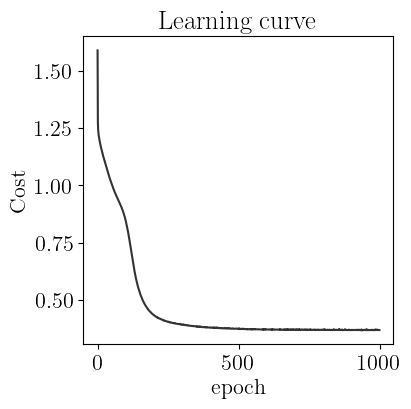

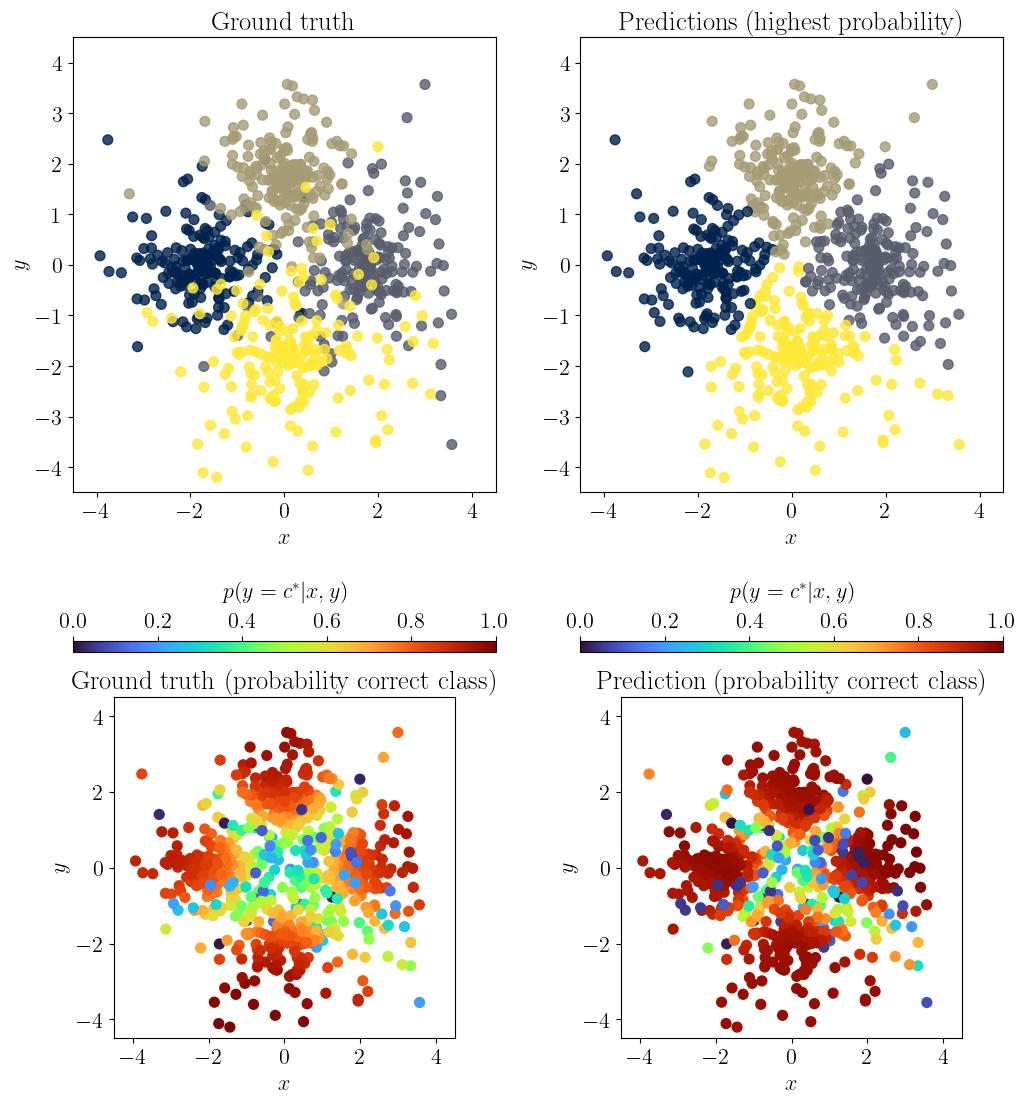

In [16]:
# Plots
from matplotlib import cm

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)


fig = plt.figure( figsize=(4, 4) )
ax_cost = fig.add_subplot(1, 1, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_title(r"Learning curve")

# ---

fig, axes = plt.subplots(2, 2, figsize=(12, 13))
ax_reference_spots = axes[0,0]
ax_pred_spots = axes[0,1]
ax_ground_truth_prob_spots =axes[1,0]
ax_nn_prob_spots = axes[1,1]


ax_reference_spots.set_xlim([-4.5,4.5])
ax_reference_spots.set_ylim([-4.5,4.5])
ax_reference_spots.set_ylabel(r"$y$")
ax_reference_spots.set_xlabel(r"$x$")
ax_reference_spots.set_title(r"Ground truth")

labels_from_ref_plot = ax_reference_spots.scatter(XY_spots[0,:],
                                                 XY_spots[1,:],
                                                 c = Y_labels,
                                                 alpha = 0.8,
                                                 s = 50,
                                                 cmap=cm.cividis,
                                                 vmin=0.0,
                                                 vmax=3.0)

# ---
ax_pred_spots.set_xlim([-4.5,4.5])
ax_pred_spots.set_ylim([-4.5,4.5])
ax_pred_spots.set_ylabel(r"$y$")
ax_pred_spots.set_xlabel(r"$x$")
ax_pred_spots.set_title(r"Predictions (highest probability)")

labels_from_probs_plot = ax_pred_spots.scatter(XY_spots[0,:],
                                              XY_spots[1,:],
                                              c = pred_spots_max_prob,
                                              alpha = 0.8,
                                              s = 50,
                                              cmap=cm.cividis,        
                                              vmin=0.0,
                                              vmax=3.0)


# Probability analysis
def probability_xy(x, y, x0, y0, sigma_r):
        dx = x-x0
        dy = y-y0
        r = np.sqrt(dx**2 + dy**2)
        p = np.exp( - (r-0)**2 /(2*sigma_r**2)) / \
                np.sqrt(2*np.pi*sigma_r**2)

        return p


ground_probs = np.zeros((4, 4*n_vals))
ground_probs[0,:] = probability_xy(XY_spots[0,:], XY_spots[1,:], S1_r0[0], S1_r0[1], S1_sigma_r)
ground_probs[1,:] = probability_xy(XY_spots[0,:], XY_spots[1,:], S2_r0[0], S2_r0[1], S2_sigma_r)
ground_probs[2,:] = probability_xy(XY_spots[0,:], XY_spots[1,:], S3_r0[0], S3_r0[1], S3_sigma_r)
ground_probs[3,:] = probability_xy(XY_spots[0,:], XY_spots[1,:], S4_r0[0], S4_r0[1], S4_sigma_r)
ground_probs = ground_probs/np.sum(ground_probs, axis=0)
prob_correct = np.max(ground_probs *  one_hot_Y_labels, axis=0)


ax_ground_truth_prob_spots.set_xlim([-4.5,4.5])
ax_ground_truth_prob_spots.set_ylim([-4.5,4.5])
ax_ground_truth_prob_spots.set_ylabel(r"$y$")
ax_ground_truth_prob_spots.set_xlabel(r"$x$")
ax_ground_truth_prob_spots.set_title(r"Ground truth (probability correct class)")

labels_ground_probs_analysis_plot = ax_ground_truth_prob_spots.scatter(XY_spots[0,:],
                                                                        XY_spots[1,:],
                                                                        c = prob_correct,
                                                                        s = 50,
                                                                        cmap=cm.turbo,        
                                                                        vmin=0.0,
                                                                        vmax=1.0)

cbar_res_ground_truth_probs_spots = plt.colorbar(labels_ground_probs_analysis_plot,
                                                ax=ax_ground_truth_prob_spots,
                                                orientation='horizontal',
                                                location='top',
                                                pad=0.1,
                                                aspect=40)

cbar_res_ground_truth_probs_spots.set_label(r'$p(y = c^* | x, y)$',  labelpad=10)

# ---
ax_nn_prob_spots.set_xlim([-4.5,4.5])
ax_nn_prob_spots.set_ylim([-4.5,4.5])
ax_nn_prob_spots.set_ylabel(r"$y$")
ax_nn_prob_spots.set_xlabel(r"$x$")
ax_nn_prob_spots.set_title(r"Prediction (probability correct class)")

p_rel = pred_spots/np.sum(pred_spots, axis=0)
prob_correct_nn = np.max(p_rel *  one_hot_Y_labels, axis=0)

labels_nn_probs_analysis_plot = ax_nn_prob_spots.scatter(XY_spots[0,:],
                                                        XY_spots[1,:],
                                                        c = prob_correct_nn,
                                                        s = 50,
                                                        cmap=cm.turbo,        
                                                        vmin=0.0,
                                                        vmax=1.0)

cbar_res_probs_spots = plt.colorbar(labels_nn_probs_analysis_plot,
                                        ax=ax_nn_prob_spots,
                                        orientation='horizontal',
                                        location='top',
                                        pad=0.1,
                                        aspect=40)

cbar_res_probs_spots.set_label(r'$p(y = c^* | x, y)$',  labelpad=10)



ax_ground_truth_prob_spots.set_aspect('equal')
ax_nn_prob_spots.set_aspect('equal')
    
plt.show()

### Example 5.2. MNIST handwritten number recognition

The recognition of handwritten digits using the MNIST database is a classical exercise for demonstrating how neural networks can be applied to complex classification tasks. In this case, we use the MNIST dataset from the Scikit-learn library, and the IAcobus libary is employed for classification.

We train and test the model independently, achieving a classification accuracy of approximately $\approx$ 95% on the test set. Upon inspecting the misclassified digits, we observe that many of these examples are difficult for humans to classify as well. To further evaluate the model's performance, we use a confusion matrix along with widely-used metrics such as precision, recall, and F1-score. These metrics indicate that the model's ability to predict different digits is generally consistent, with only slight variations between different training sets.

The only notable discrepancy is observed in the prediction of the digit 8, which is often misclassified as either 1 or 2. This is likely due to the ambiguous appearance of some handwritten 8s, where the traces may be unclear, leading to confusion with other digits

In [3]:
from sklearn import datasets

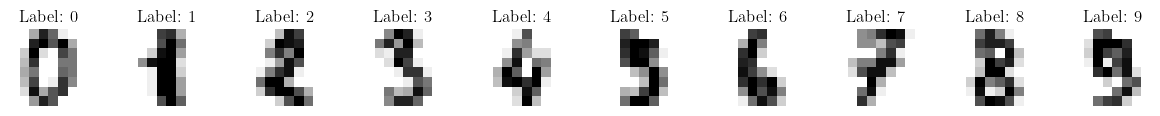

In [93]:
# Loads MNIST set
numbers_data = datasets.load_digits()
numbers_pixels = numbers_data.data.T
numbers_labels = numbers_data.target
total_pixels = numbers_pixels.shape[0]
wh = int(np.sqrt(total_pixels))

# Show the first 10 samples
SAMPLES_TO_PLOT = 10

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('text', usetex=True)
plt.rc('font', **font)

fig, axes = plt.subplots(1, SAMPLES_TO_PLOT, figsize=(SAMPLES_TO_PLOT*1.5, 1))
for i in range(0, SAMPLES_TO_PLOT):
    axes[i].imshow(numbers_pixels[:,i].reshape(wh,wh), cmap=plt.cm.gray_r)
    axes[i].axis('off')
    axes[i].set_title('Label: %i' % numbers_labels[i], fontsize = 12)

In [94]:
n_inputs = total_pixels
topology = [32, 32, 10]
activation_funcs = ['relu',
                    'relu',
                    'softmax']

ryc = IAcobus(n_inputs,
                topology,
                activation_funcs,
                cost_func='cross-entropy')


# A) Pre-process the data
# i. One hot encode and split in test and train sets
one_hot_number_labels = ryc.one_hot_encoding(numbers_labels, 10)
numbers_pixels_train, one_hot_numbers_labels_train, numbers_pixels_test, one_hot_numbers_labels_test  =  ryc.split_data_train_test(numbers_pixels,
                                                                                                                                    one_hot_number_labels,
                                                                                                                                    p_train=0.6)

# ii. Rescale
PIX_MAX = np.max(numbers_pixels_train)
PIX_MIN = np.min(numbers_pixels_train)
numbers_pixels_train = (numbers_pixels_train - PIX_MIN)/(PIX_MAX - PIX_MIN)
numbers_pixels_test = (numbers_pixels_test - PIX_MIN)/(PIX_MAX - PIX_MIN)



# Train the model
cost = ryc.train(numbers_pixels_train, one_hot_numbers_labels_train,
                 num_epochs=8_000,
                 batch_size=50,
                 learning_rate=1e-3,
                 algorithm='adopt',
                 verbose=True)

Cost: 4.3388e-07;   Epoch: 7990/8000: 100%|██████████| 8000/8000 [01:35<00:00, 84.02it/s] 


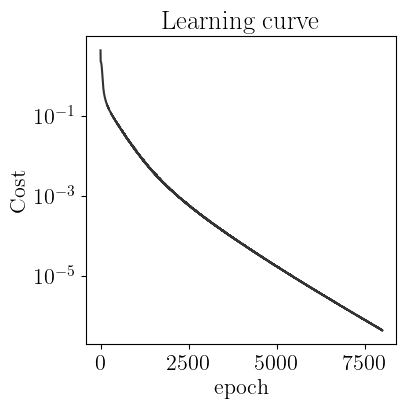

In [95]:
fig = plt.figure( figsize=(4, 4) )
ax_cost = fig.add_subplot(1, 1, 1)

ax_cost.plot(cost, color='#333333')
ax_cost.set_ylabel(r"Cost")
ax_cost.set_xlabel(r"epoch")
ax_cost.set_title(r"Learning curve")
ax_cost.set_yscale('log')

In [96]:
# Show accuracy in train and test sets

def det_accuracy(pred_probs, true_labels_one_hot):
    pred_max_prob_labels = np.argmax(pred_probs, axis=0)
    true_labels =  np.argmax(true_labels_one_hot, axis=0)
    true_vs_pred = np.where( (pred_max_prob_labels - true_labels)==0, 1, 0)
    return 100*np.sum(true_vs_pred)/len(true_vs_pred)

pred_numbers_test = ryc.forward(numbers_pixels_test)
pred_numbers_train = ryc.forward(numbers_pixels_train)

accuracy_test = det_accuracy(pred_numbers_test, one_hot_numbers_labels_test)
accuracy_train= det_accuracy(pred_numbers_train, one_hot_numbers_labels_train)

print(f"Accuracy train set = {accuracy_test:.2f}%")
print(f"Accuracy test set = {accuracy_train:.2f}%")

Accuracy train set = 94.85%
Accuracy test set = 100.00%


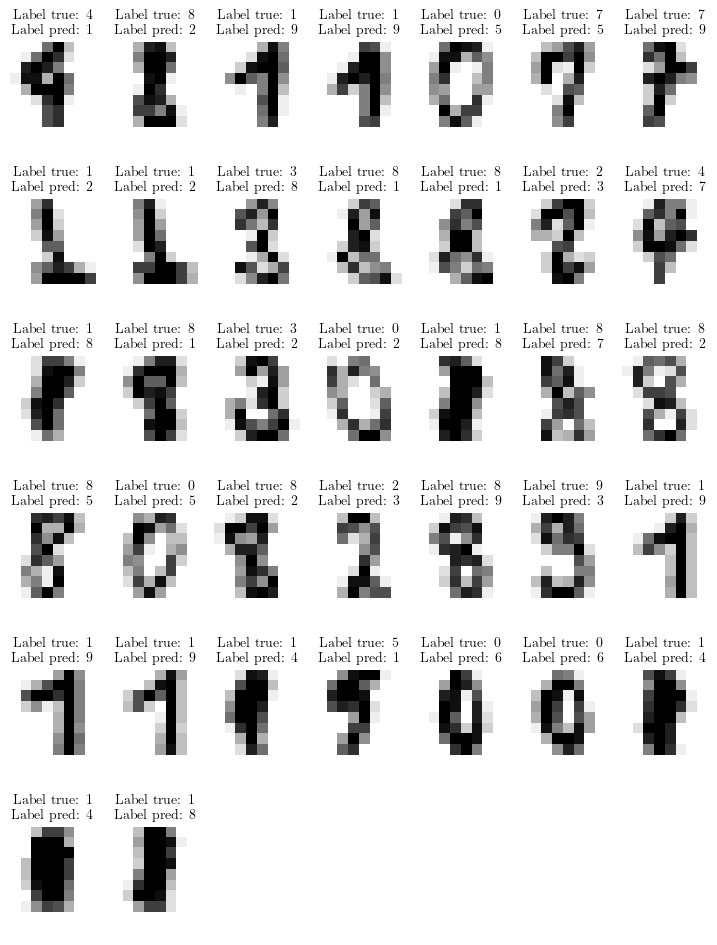

In [107]:
# Show images that are not correctly classified

def find_wrongly_classified_numbers(images, pred_probs, true_labels_one_hot):
    """ 
        Returns those images that have been wrongly classified
    """
    pred_max_prob_labels = np.argmax(pred_probs, axis=0)
    true_labels =  np.argmax(true_labels_one_hot, axis=0)
    true_vs_pred = np.where( (pred_max_prob_labels - true_labels)==0, 0, 1)
    wrong_images = numbers_pixels_test[:,true_vs_pred==1]
    
    labels_wrong_images =  pred_max_prob_labels[true_vs_pred==1]
    true_labels_wrong_images = true_labels[true_vs_pred==1]

    return wrong_images, labels_wrong_images, true_labels_wrong_images

wrongly_classified_images, labels_wrong_images, true_labels_wrong_images = find_wrongly_classified_numbers(numbers_pixels_test, pred_numbers_test, one_hot_numbers_labels_test)
n_wrong = wrongly_classified_images.shape[1]
n_plots_cols = int(np.ceil(np.sqrt(n_wrong)))
n_plots_rows = int(np.ceil(n_wrong/n_plots_cols))


fig, axes = plt.subplots(n_plots_rows, n_plots_cols, figsize=(n_plots_rows*1.5, n_plots_cols*1.7))

col = 0
row = 0
for img_number, lbl_pred, lbl_class in zip(wrongly_classified_images.T, labels_wrong_images, true_labels_wrong_images):
    axes[row, col].imshow(img_number.reshape(wh,wh), cmap=plt.cm.gray_r)
    axes[row, col].set_title(f'Label true: {lbl_class}\n Label pred: {lbl_pred}', fontsize = 10)

    col += 1
    if col==n_plots_cols:
        col = 0
        row += 1

for i in range(n_plots_rows):
    for j in range(n_plots_cols):
        axes[i, j].axis('off')

plt.show()


Text(0, 0.5, '$p_{ij}$')

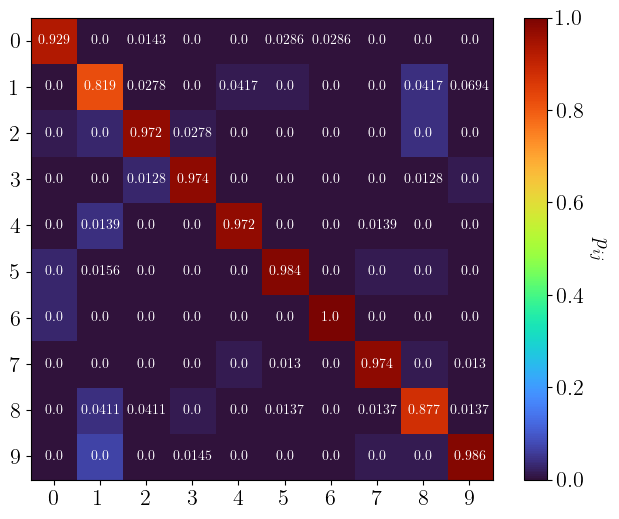

In [109]:
# Determine Confusion Matrix
def calculate_confussion_matrix(pred_probs, true_labels_one_hot):
    """
        Find the confussion matrix from the predicted probabilities
        and the true labels.
    """ 
    pred_max_prob_labels = np.argmax(pred_probs, axis=0)
    true_labels =  np.argmax(true_labels_one_hot, axis=0)

    confussion_matrix = np.zeros((10,10))
    for i in range(0,10):
        for j in range(0,10):
            confussion_matrix[i,j] = np.sum( (pred_max_prob_labels[:]==i) & (true_labels==j)  )

    confussion_matrix_norm = confussion_matrix/np.sum(confussion_matrix, axis=0) 
    return confussion_matrix_norm, confussion_matrix

conf_matrix_norm, conf_matrix = calculate_confussion_matrix(pred_numbers_test, one_hot_numbers_labels_test)

# Plot 
fig, ax = plt.subplots( figsize=(8,6) )
im = ax.imshow(conf_matrix_norm, cmap='turbo')

# Create text annotations.
for i in range(10):
    for j in range(10):
        text = ax.text(i, j,  float('%.3g' % conf_matrix_norm[i, j]), 
                       fontsize=10,
                       ha="center", 
                       va="center", 
                       color="w")

ax.set_yticks(np.arange(10))
ax.set_xticks(np.arange(10))

# Color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("$p_{ij}$", rotation=-90, va="bottom")

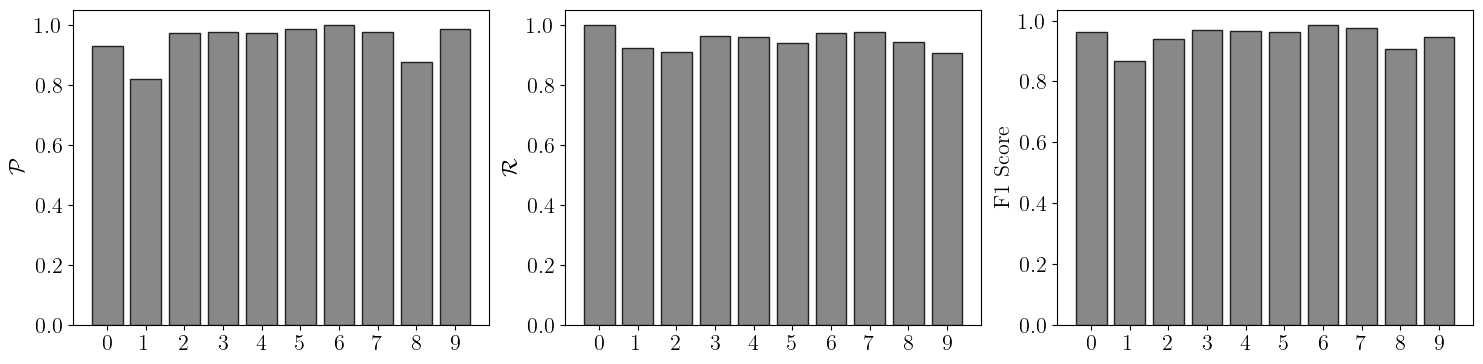

In [110]:
# Find precission, recall, and F1-Score
def find_precission_recall_f1_score(confusion_matrix):
    """ 
        Use the confussion matrix to compute performance metrics
    """
    precission = np.diagonal(confusion_matrix)/np.sum(confusion_matrix, axis=0)
    recall = np.diagonal(confusion_matrix)/np.sum(confusion_matrix, axis=1)
    f1_score = 2*precission*recall/(precission + recall)

    return precission, recall, f1_score

precission, recall, f1_score = find_precission_recall_f1_score(conf_matrix)

# Plot
fig, (ax_p, ax_r, ax_f1) = plt.subplots(1, 3, figsize=(15, 4))
fig.tight_layout() 
            
ax_p.bar(np.arange(10), precission,  color='#888888',  edgecolor="#222222")
ax_p.set_ylabel(r"$\mathcal{P}$")
ax_p.set_xticks(np.arange(10))

ax_r.bar(np.arange(10), recall,  color='#888888',  edgecolor="#222222")
ax_r.set_ylabel(r"$\mathcal{R}$")
ax_r.set_xticks(np.arange(10))

ax_f1.bar(np.arange(10), f1_score,  color='#888888',  edgecolor="#222222")
ax_f1.set_ylabel(r"F1 Score")
ax_f1.set_xticks(np.arange(10))

<h4 align="center">
    César L. Pastrana (c) 2024
</h4>